# SpikeInterface Tutorial -  GDR School Lyon - October 2022


In this practice, you will use SpikeInterface to analyze a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is kindly provided by [Samuel McKenzie's Lab](https://mckenzieneurolab.com/). 

The objective of this practice is for you to familiarize with SpikeInterface on a real-world example and to explore its capabilities and functionalities.

This notebook is very similar to the demo.

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Viewers](#viewers)
* [8. Validation and curation](#curation)
* [9. Spike sorting comparison](#comparison)


# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording (you should have this already). Feel free to use your own recordings as well later on. 

The dataset is called `cambridge_data.dat` and can be found on this [drive link](https://drive.google.com/drive/folders/1eWPuOd8q4MjpVpwazkWygQJDzJnToN3i) (`practice_2_real_dataset` folder). Move the dataset in the current folder.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
%matplotlib widget

In [2]:
import spikeinterface.full as si

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path



# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [43]:
base_folder = Path('/data_local/DataSpikeSorting/data_tutorial/practice_pipeline')


In [44]:
# file path
recording_file = base_folder / 'cambridge_data.dat'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype = "int16"
time_axis = 0

In [45]:
si.read_binary?

Signature:
si.read_binary(
    file_paths,
    sampling_frequency,
    num_chan,
    dtype,
    t_starts=None,
    channel_ids=None,
    time_axis=0,
    file_offset=0,
    gain_to_uV=None,
    offset_to_uV=None,
    is_filtered=None,
)
Docstring:
RecordingExtractor for a binary format

Parameters
----------
file_paths: str or Path or list
    Path to the binary file
sampling_frequency: float
    The sampling frequency
num_chan: int
    Number of channels
dtype: str or dtype
    The dtype of the binary file
time_axis: int
    The axis of the time dimension (default 0: F order)
t_starts: None or list of float
    Times in seconds of the first sample for each segment
channel_ids: list (optional)
    A list of channel ids
file_offset: int (optional)
    Number of bytes in the file to offset by during memmap instantiation.
gain_to_uV: float or array-like (optional)
    The gain to apply to the traces
offset_to_uV: float or array-like
    The offset to apply to the traces
is_filtered: bool 

In [46]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [47]:
print(recording)

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  file_paths: ['/data_local/DataSpikeSorting/data_tutorial/practice_pipeline/cambridge_data.dat']


We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [48]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [49]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


### Exercise 1a) Explore traces

Explore the `recording.get_traces()` function. What are its arguments? What is the shape of the returned signals? What is the unit? 

Try to plot the traces of some channels using `matplotlib`.

### 1a) SOLUTION

In [50]:
# we have to extract only a chunk of the traces (let's say 5 seconds) otherwise the data would not fit on our RAM

# we can extract traces as raw int16 (default) as:
traces = recording.get_traces(start_frame=10*fs, end_frame=15*fs)

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


Text(0, 0.5, 'raw ADC output')

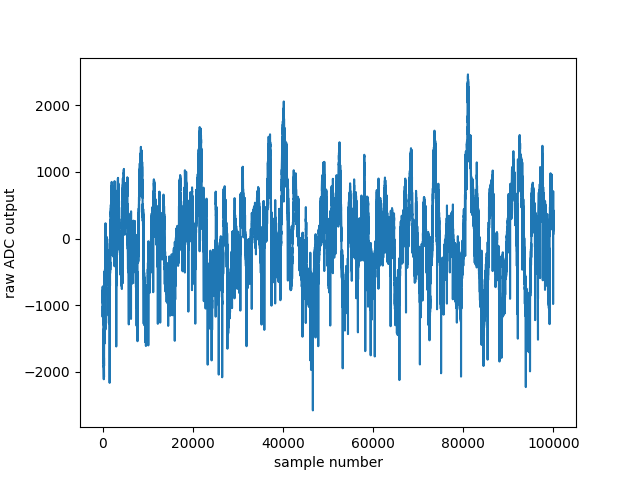

In [51]:
fix, ax = plt.subplots()
ax.plot(traces[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("raw ADC output")

In [52]:
# we can extract traces in uV with the return_scaled argument
traces_uV = recording.get_traces(start_frame=10*fs, end_frame=15*fs, return_scaled=True)

<>:4: DeprecationWarning: invalid escape sequence \m
<>:4: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_40054/2626206558.py:4: DeprecationWarning: invalid escape sequence \m
  ax.set_ylabel("$\mu$V")
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


Text(0, 0.5, '$\\mu$V')

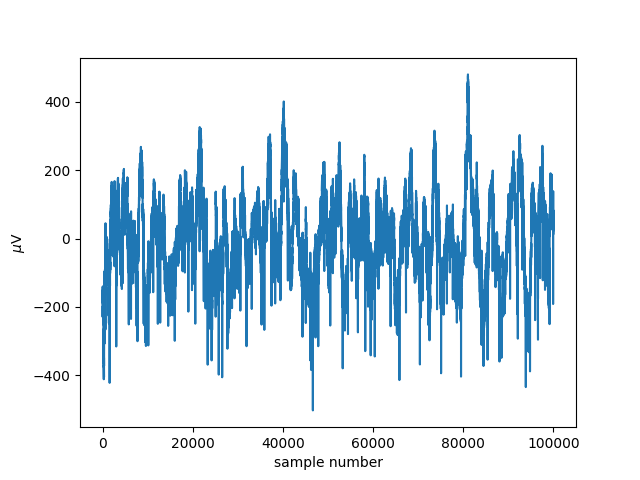

In [53]:
fix, ax = plt.subplots()
ax.plot(traces_uV[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("$\mu$V")

**IMPORTANT**: The `widgets` module includes several convenient plotting functions that can be used to explore the data:

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


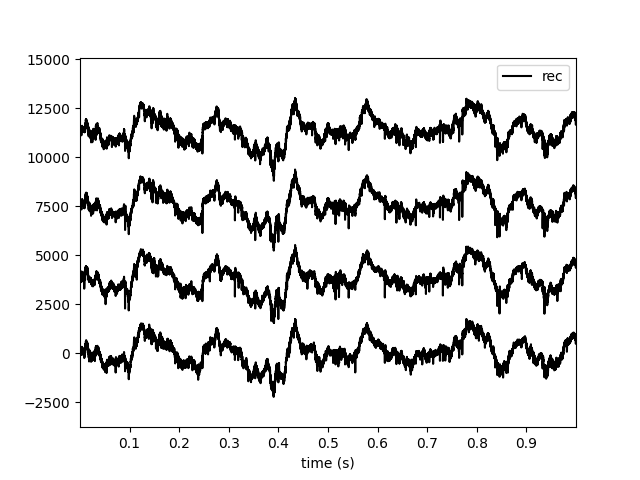

In [54]:
w_ts = si.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [55]:
import probeinterface as pi
from probeinterface import plotting

In [56]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch - 4shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [57]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [58]:
probe.wiring_to_device('ASSY-156>RHD2164')

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(<matplotlib.collections.PolyCollection at 0x7f0589e6beb0>,
 <matplotlib.collections.PolyCollection at 0x7f0589f28250>)

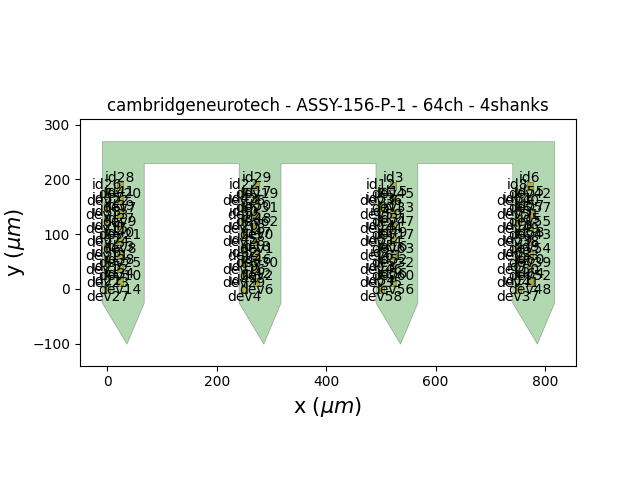

In [59]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [60]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


Note that also the `shank_id` is loaded with the probe.

In [61]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [62]:
probe_rec = recording_prb.get_probe()
df = probe_rec.to_dataframe(complete=True)
# df.loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
df

,x,y,contact_shapes,width,height,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,272.5,112.5,rect,11.0,15.0,1,48,0,um,1.0,0.0,0.0,1.0
1,272.5,87.5,rect,11.0,15.0,1,47,1,um,1.0,0.0,0.0,1.0
2,272.5,37.5,rect,11.0,15.0,1,46,2,um,1.0,0.0,0.0,1.0
3,250.0,75.0,rect,11.0,15.0,1,45,3,um,1.0,0.0,0.0,1.0
4,250.0,0.0,rect,11.0,15.0,1,44,4,um,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,500.0,150.0,rect,11.0,15.0,2,53,59,um,1.0,0.0,0.0,1.0
60,522.5,37.5,rect,11.0,15.0,2,52,60,um,1.0,0.0,0.0,1.0
61,500.0,75.0,rect,11.0,15.0,2,51,61,um,1.0,0.0,0.0,1.0
62,272.5,137.5,rect,11.0,15.0,1,50,62,um,1.0,0.0,0.0,1.0


In [63]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [64]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [65]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [66]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [67]:
group_to_sort = 2

In [68]:
recording_to_process = recordings_by_group[2]

Below, we bandpass filter the recording:

In [69]:
recording_f = si.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)



/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


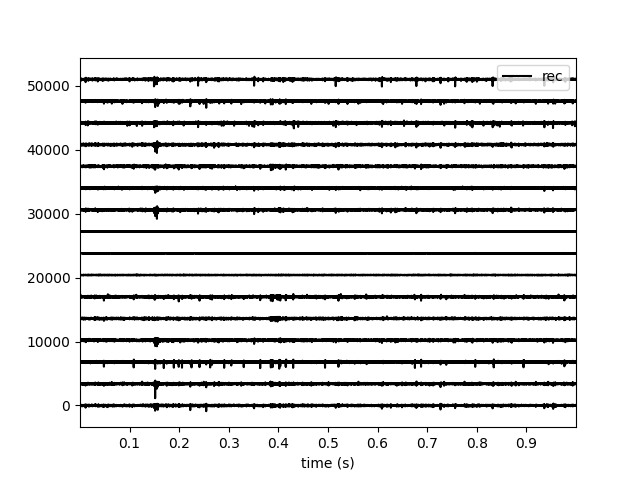

In [70]:
w = si.plot_timeseries(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

### Exercise 2a) Explore noise reduction methods

We can use the `preprocessing` module to further increase the quality of the traces before spike sorting.
Several available preprocessors are available for this purpose.

- Explore the `spikeinterface.preprocessing` module to find functions that could remove noise (e.g. by re-referencing the signal).

- Choose a preprocessing step and apply it to the filtered recording (`recording_f`)

- Compare the traces to the filtered traces

### 2a) SOLUTION 


We are going to use toe `common_reference` function. Depending on the nature of noise, other preprocessing steps may be appropriate:

* `remove_bad_channels`: some channels have very high noise compared to others
* `notch_filter`: 50-60Hz line interference or localized noise sources
* `remove_artifacts`: blank out or interpolate artifacts due to, for example, electrical stimulation

In [71]:
si.common_reference?

Signature:
si.common_reference(
    recording,
    reference='global',
    operator='median',
    groups=None,
    ref_channel_ids=None,
    local_radius=(30, 55),
    verbose=False,
)
Docstring:
Re-references the recording extractor traces.

Parameters
----------
recording: RecordingExtractor
    The recording extractor to be re-referenced
reference: str 'global', 'single' or 'local'
    If 'global' then CMR/CAR is used either by groups or all channel way.
    If 'single', the selected channel(s) is remove from all channels. operator is no used in that case.
    If 'local', an average CMR/CAR is implemented with only k channels selected the nearest outside of a radius around each channel
operator: str 'median' or 'average'
    If 'median', common median reference (CMR) is implemented (the median of
        the selected channels is removed for each timestamp).
    If 'average', common average reference (CAR) is implemented (the mean of the selected channels is removed
        for each 

In [72]:
recording_cmr_global = si.common_reference(recording_f, reference="global", operator="median")

In [73]:
recording_cmr_local = si.common_reference(recording_f, reference="local", operator="median", local_radius=(30, 55),)

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


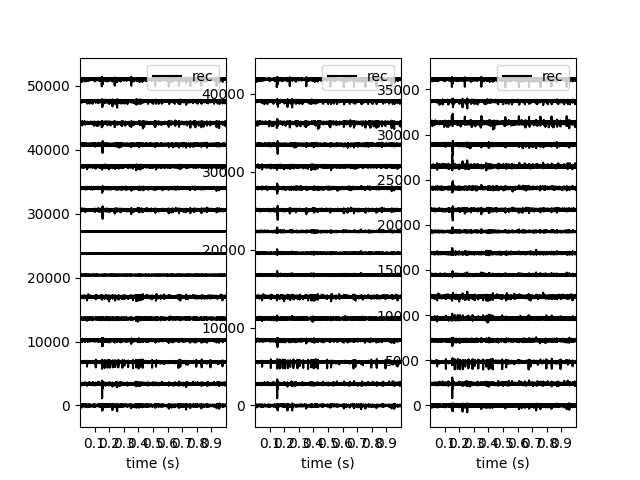

In [74]:
fig, axs = plt.subplots(ncols=3)
si.plot_timeseries(recording_f, ax=axs[0])
si.plot_timeseries(recording_cmr_global, ax=axs[1])
si.plot_timeseries(recording_cmr_local, ax=axs[2])

In [75]:
si.plot_timeseries({'filtered': recording_f, 'global':recording_cmr_global, 'local':recording_cmr_local}, backend='ipywidgets')

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

In [76]:
# Use the right object to continue with the analysis
recording_processed = recording_f

### Exercise 2b) Visual exploration preprocessing methods with `ephyviewer`

In [77]:
import ephyviewer

In [64]:
app = ephyviewer.mkQApp()
win = ephyviewer.MainViewer(debug=False, show_auto_scale=True)

In [65]:
sig_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_to_process)
sig_filtered_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_f)

In [66]:
view1 = ephyviewer.TraceViewer(source=sig_source, name='signals')
view1.params['scale_mode'] = 'same_for_all'
win.add_view(view1)

view2 = ephyviewer.TraceViewer(source=sig_filtered_source, name='signals filtered')
view2.params['scale_mode'] = 'same_for_all'
win.add_view(view2)

In [67]:
# you can add more views here!

sig_cmr_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_cmr_global)

view3 = ephyviewer.TraceViewer(source=sig_cmr_source, name='signals cmr')
view3.params['scale_mode'] = 'same_for_all'
win.add_view(view3)

In [68]:
win.show()
app.exec_()

0

<img src="ephyviewer.png" />

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [78]:
fs = recording_processed.get_sampling_frequency()
recording_sub = recording_processed.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [79]:
recording_saved = recording_sub.save(folder=base_folder / "preprocessed", 
                                     n_jobs=4, chunk_duration="1s", progress_bar=True, )

write_binary_recording with n_jobs = 4 and chunk_size = 20000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

The `save` returns a new *cached* recording that has all the previously loaded information:

In [80]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [17 32 33 34 35 36 44 45 46 47 56 58 59 60 61 63]
Channel groups after caching: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


After saving the SI object, we can easily load it back in a new session:

In [81]:
recording_loaded = si.load_extractor("preprocessed/")

We can double check that the traces are exactly the same as the `recording_saved` that we saved:

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording.

Let's first check the installed sorters in SpikeInterface.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [82]:
si.installed_sorters()

RUNNING SHELL SCRIPT: /tmp/tmp_shellscript6dyn86o4/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscripty75du9bm/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscripti5oacygq/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptbyuh1s19/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptfkfbt77r/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscript6hvl31ic/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscript5wh90opy/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscripteffy30t_/script.sh


/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/yass/config/config.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableSequence
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/yass/config/config.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableSequence


['herdingspikes',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [83]:
sorter_name = 'tridesclous'

In [84]:
si.get_default_params(sorter_name)

/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/sorters/sorterlist.py:98: DeprecationWarning: Use get_default_sorter_params() function instead
  warnings.warn("Use get_default_sorter_params() function instead",


{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'common_ref_removal': False,
 'nested_params': None,
 'n_jobs': 1,
 'total_memory': None,
 'chunk_size': None,
 'chunk_memory': None,
 'chunk_duration': '1s',
 'progress_bar': True}

In [85]:
si.get_params_description(sorter_name)

/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/sorters/sorterlist.py:128: DeprecationWarning: Use get_sorter_params_description() function instead
  warnings.warn("Use get_sorter_params_description() function instead",


{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'common_ref_removal': 'remove common reference with median',
 'n_jobs': 'Number of jobs (when saving ti binary) - default 1',
 'chunk_size': 'Number of samples per chunk (when saving ti binary) - default None',
 'chunk_memory': "Memory usage for each job (e.g. '100M', '1G') (when saving to binary) - default None",
 'total_memory': "Total memory usage (e.g. '500M', '2G') (when saving to binary) - default None",
 'chunk_duration': "Chunk duration in s if float or with units if str (e.g. '1s', '500ms') (when saving to binary) - default '1s'",
 'progress_bar': 'If True, progress bar is shown (when saving to binary) - default True'}

### Exercise 4a) Spike sort your data

The `si.run_sorter()` function from the `sorters` module is where the spike sorting happens! The function returns a `SortingExtractor` object, which allows you to retrieve spiking data (e.g. unit ids, spike trains, etc.)

Run a spike sorter installed on your system and explore the returned `SortingExtractor` object.

In [ ]:
si.run_sorter?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

### 4a) SOLUTION

In [106]:
# run spike sorting on entire recording
sorting_TDC = si.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                        output_folder=base_folder / "output_TDC", verbose=True)

DataIO <id: 139663441137424> 
  workdir: /data_local/DataSpikeSorting/data_tutorial/practice_pipeline/output_TDC
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
               

In [107]:
print(sorting_TDC)

print("Unit ids:", sorting_TDC.get_unit_ids())

TridesclousSortingExtractor: 21 units - 1 segments - 20.0kHz
Unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [108]:
print("Spike train of unit 0:", sorting.get_unit_spike_train(0))

Spike train of unit 0: [  36298   67678   97102  181291  199488  243544  431637  610183  617536
  623508  887884 1514259 2359616 2596064 2603380 2605046 2610208 2614062
 2615163 2629186 2984573 2988558 3038616 3040279 3110917 3116966 3151751
 3155561 3161254 3174531 3177270 3333801 3377919 3381872 3449469 3453161
 3456139 3457452 3463009 3464339 3471170 3472760 3493476 3494349 3495022
 3518675 3521880 3527513 3538239 3575242 3594972 3598785 3605163 3608526
 3616567 3627536 3636749 3785255 3883533 3898676 3988635 3990458 3992134
 3993459 3994239 3994878 3996527 3996652 3996874 3999510 4000387 4001060
 4005693 4007744 4008993 4011466 4024732 4052827 4053947 4054278 4054687
 4055970 4057564 4057960 4058668 4058970 4059554 4060094 4060774 4061324
 4062702 4063530 4064865 4066425 4067703 4068433 4069194 4072848 4076026
 4077290 4094469 4097425 4099204 4107403 4117511 4164897 4168124 4171387
 4205435 4224321 4228907 4230581 4268412 4274197 4277945 4280439 4282956
 4285640 4291459 4296154 429

### Exercise 4b) Change a spike sorter parameter

Parameters (listed above) can be directly passed as extra arguments to the `si.run_sorter()` function.

Try to choose a parameter, change its default value, and run spike sorting again


### 4b) SOLUTION

Let's try to increase the detection threshold!

In [95]:
# run spike sorting on entire recording
sorting_TDC3 = si.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                         output_folder=base_folder/"output_TDC_thr3", detect_threshold=3, verbose=True)

DataIO <id: 139663769036256> 
  workdir: /data_local/DataSpikeSorting/data_tutorial/practice_pipeline/output_TDC_thr3
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
          

In [94]:
print(sorting_TDC3)

print("Unit ids:", sorting_TDC3.get_unit_ids())

TridesclousSortingExtractor: 6 units - 1 segments - 20.0kHz
Unit ids: [0 1 2 3 4 5]


## exercice 4c

Run spykingcicus2

## Solution 4c

In [96]:
sorting_SC2 = si.run_sorter(sorter_name="spykingcircus2", recording=recording_saved,
                         output_folder=base_folder/"output_TDC_thr3", verbose=True)

detect peaks with n_jobs = 40 and chunk_size = 20000


detect peaks:   0%|          | 0/300 [00:00<?, ?it/s]

We found 35896 peaks in total
We kept 35896 peaks for clustering
localize peaks with n_jobs = 40 and chunk_size = 20000


localize peaks:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap with n_jobs = 40 and chunk_size = 20000


extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

We found 20 raw clusters, starting to clean with cosine...
extract waveforms memmap with n_jobs = 40 and chunk_size = 20000


extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

We kept 20 non-duplicated clusters...
extract waveforms memmap with n_jobs = 40 and chunk_size = 20000


extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp) with n_jobs = 40 and chunk_size = 2000


find spikes (circus-omp):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 80 spikes
spykingcircus2 run time 23.23s


In [98]:
print(sorting_SC2)

print("Unit ids:", sorting_SC2.get_unit_ids())

NpzSortingExtractor: 12 units - 1 segments - 20.0kHz
  file_path: /data_local/DataSpikeSorting/data_tutorial/practice_pipeline/output_TDC_thr3/sorting/sorting_cached.npz
Unit ids: [ 0  1  2  3  4  5  6  7  9 10 18 19]


## excercie 4d (optional)

Spike sort in Docker containers

If you have docker installed try to play with the **docker_image** option
For instance::
  * `docker_image="spikeinterface/spyking-circus-base:1.0.7"`
  * `docker_image=True`

And try to run spkykingcircus.


## Solution 4d

In [102]:
sorting_SC = si.run_spykingcircus(recording_saved, output_folder=base_folder/"results_SC",
                                  docker_image="spikeinterface/spyking-circus-base:1.0.7",
                                  verbose=True)

Starting container
Installing spikeinterface from sources in spikeinterface/spyking-circus-base:1.0.7
Installing dev spikeinterface from remote repository
Running spykingcircus sorter inside spikeinterface/spyking-circus-base:1.0.7
Stopping container


In [103]:
print(sorting_SC)

print("Unit ids:", sorting_SC.get_unit_ids())

SpykingCircusSortingExtractor: 46 units - 1 segments - 20.0kHz
Unit ids: [ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3
 30 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45  5  6  7  8  9]


/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


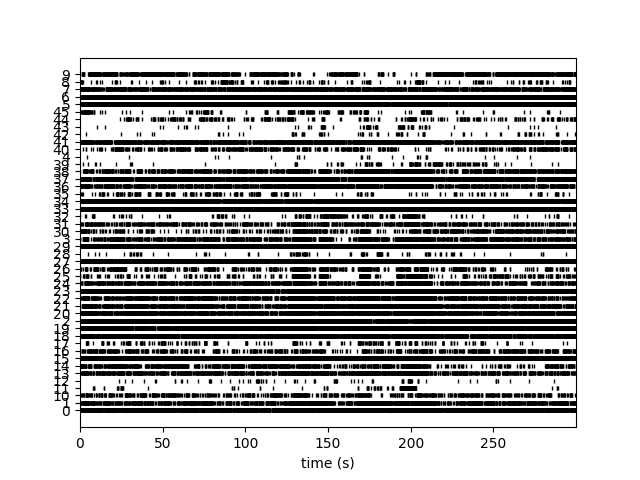

In [104]:
si.plot_rasters(sorting_SC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [110]:
sorting = sorting_TDC

In [ ]:
si.extract_waveforms?

In [113]:
we = si.extract_waveforms(recording_saved, sorting_TDC, folder=base_folder/"waveforms_TDC", progress_bar=True,
                          n_jobs=4, total_memory="500M", overwrite=True)
print(we)

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

WaveformExtractor: 16 channels - 21 units - 1 segments
  before:60 after:80 n_per_units:500


Now all waveforms are computed and stored in the provided `waveforms_TDC` folder. We can now retrieve waveforms and templates easily.

### Exercise 5a) Explore waveforms and templates

The `WaveformExtractor` object (`we`) has convenient functions to retrieve waveforms and templates (average waveforms).

- Retrieve some waveforms and templates and inspect them
- Are waveform extracted from all spikes? If not, can you explore the function docs and find a way to compute waveforms for all spikes?


### 5a) SOLUTION

We can access waveforms for single units with the `get_waveforms` and `get_template` functions. 


In [114]:
waveforms0 = we.get_waveforms(unit_id=0)
template0 = we.get_template(unit_id=0)

print(waveforms0.shape)
print(template0.shape)

(200, 140, 16)
(140, 16)


/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


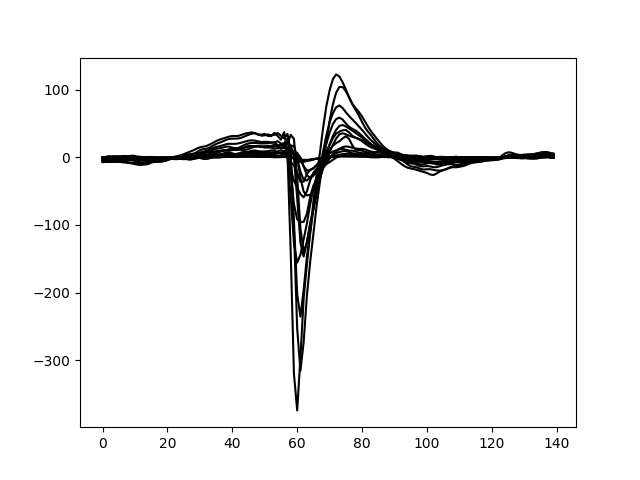

In [115]:
# let's plot a template
fig = plt.figure()
_ = plt.plot(template0, color="k")

### Exercise 5b) Find `widgets` for plotting waveforms

Use the `widgets` module to visualize waveform extractor objects

### 5b) SOLUTION

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


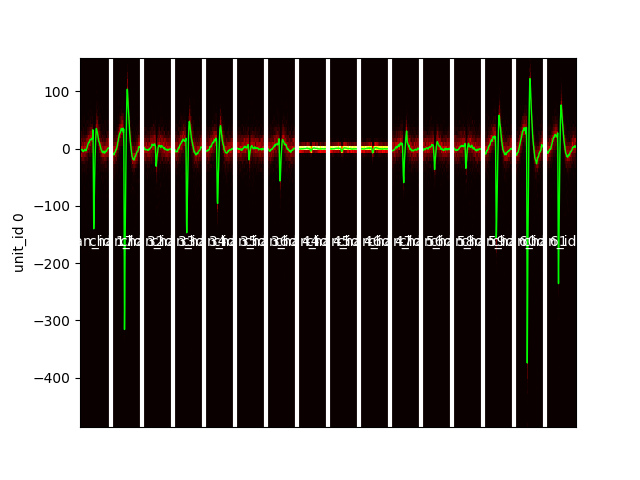

In [120]:
si.plot_unit_waveforms_density_map(we, unit_ids=[0])

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


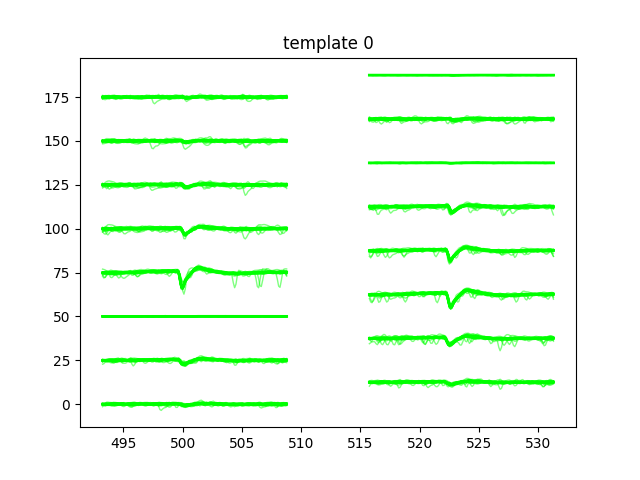

In [122]:
si.plot_unit_waveforms(we, unit_ids=[0])

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


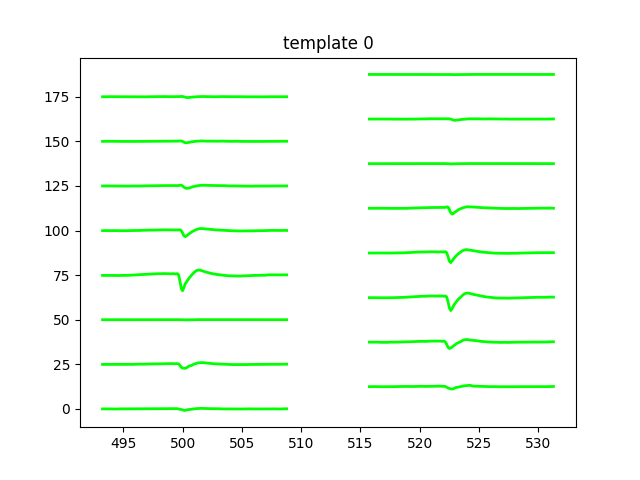

In [124]:
si.plot_unit_templates(we, unit_ids=[0])

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


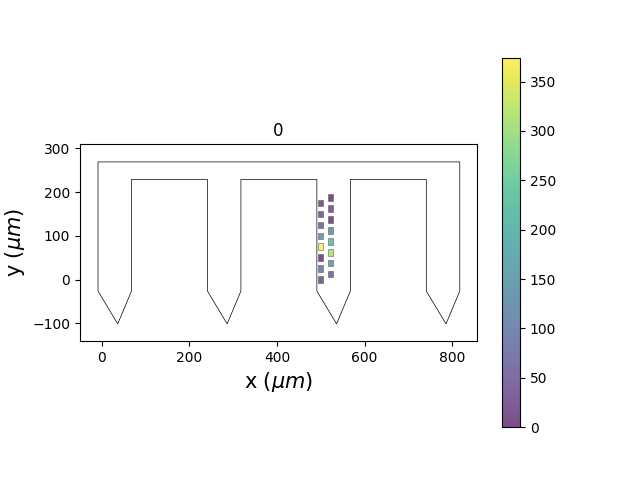

In [125]:
si.plot_unit_probe_map(we, unit_ids=[0])

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


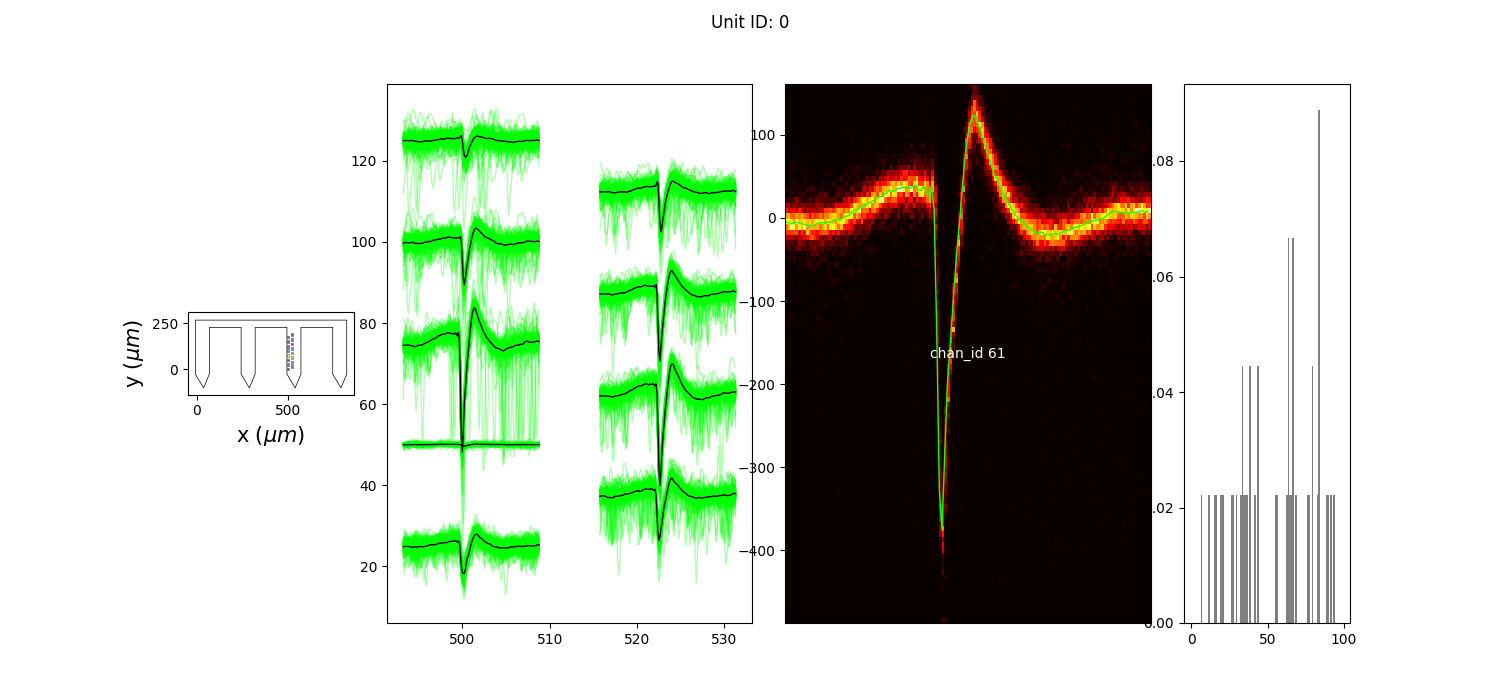

In [127]:
si.plot_unit_summary(we, unit_id=0)

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [128]:
pc = si.compute_principal_components(we, n_components=3)

In [133]:
pc0 = pc.get_projections(unit_id=0)
# all_labels, all_pcs = pc.get_all_components()
pc0.shape

(200, 3, 16)

In [135]:
all_labels, all_pcs = pc.get_all_projections()
all_pcs.shape

(9133, 3, 16)

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_projections()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Exercise 6a) Plot pca projections

Explore the principal component space and amplitudes using `matplotlib`

- Plot projections of two units on multiple channels and pc components


### 6a) SOLUTION

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


Text(0, 0.5, 'PC1 - channel ind 12')

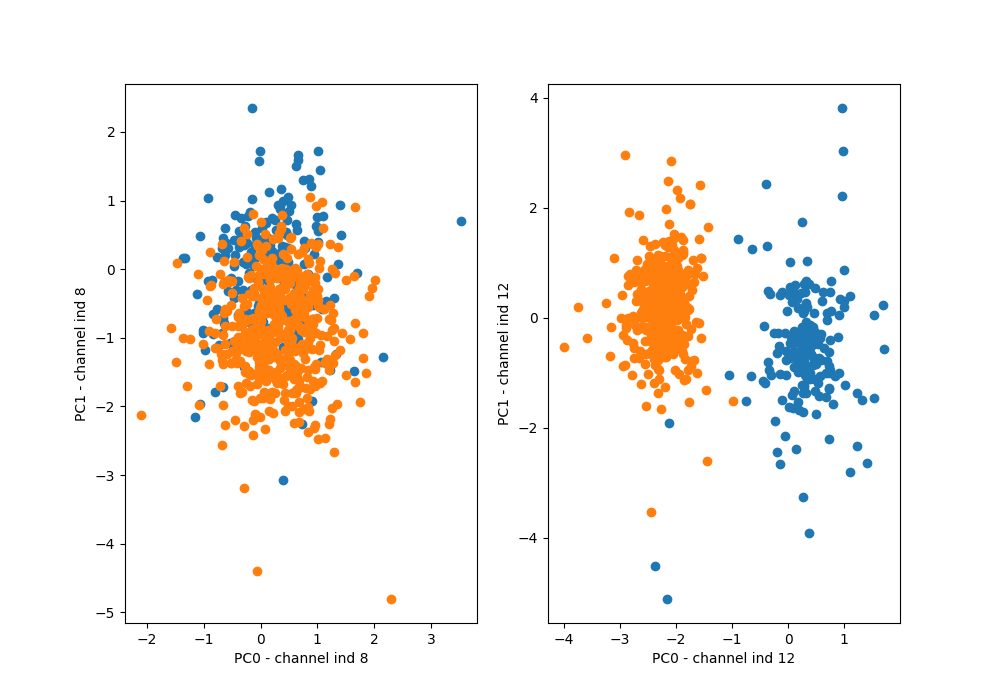

In [166]:
# Explore pc and amplitudes
pc0 = pc.get_projections(unit_id=0)
pc1 = pc.get_projections(unit_id=1)


fig, axs = plt.subplots(ncols=2, figsize=(10,7))

# let's plot the projections on the first 2 components choose 2 channel indices
channel_ind1 = 8
channel_ind2 = 12


axs[0].scatter(pc0[:, 0, channel_ind1], pc0[:, 1, channel_ind1])
axs[0].scatter(pc1[:, 0, channel_ind1], pc1[:, 1, channel_ind1])
axs[0].set_xlabel(f"PC0 - channel ind {channel_ind1}")
axs[0].set_ylabel(f"PC1 - channel ind {channel_ind1}")

axs[1].scatter(pc0[:, 0, channel_ind2], pc0[:, 1, channel_ind2])
axs[1].scatter(pc1[:, 0, channel_ind2], pc1[:, 1, channel_ind2])
axs[1].set_xlabel(f"PC0 - channel ind {channel_ind2}")
axs[1].set_ylabel(f"PC1 - channel ind {channel_ind2}")

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [153]:
amplitudes = si.compute_spike_amplitudes(we, chunk_duration='1s', n_jobs=4, progress_bar=True)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

In [167]:
si.plot_amplitudes(we, backend='ipywidgets')

AppLayout(children=(Checkbox(value=False, description='plot histograms', layout=Layout(grid_area='footer')), V…

## unit locations

In [172]:
unit_loc = si.compute_unit_locations(we, method='monopolar_triangulation')

In [173]:
si.plot_unit_locations(we, backend='ipywidgets')

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, …

## spike locations

In [175]:
spike_loc = si.compute_spike_locations(we, method='monopolar_triangulation', n_jobs=4, chunk_duration='1s', progress_bar=True)

localize peaks:   0%|          | 0/300 [00:00<?, ?it/s]

In [177]:
si.plot_spike_locations(we, backend='ipywidgets')

AppLayout(children=(VBox(children=(Label(value='units:'), SelectMultiple(index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, …

## correlogram

In [179]:
si.compute_correlograms?

Signature:
si.compute_correlograms(
    waveform_or_sorting_extractor,
    load_if_exists=False,
    window_ms: float = 100.0,
    bin_ms: float = 5.0,
    symmetrize: bool = True,
    method: str = 'auto',
)
Docstring:
Compute auto and cross correlograms.

Parameters
----------
waveform_or_sorting_extractor : WaveformExtractor or BaseSorting
    If WaveformExtractor, the correlograms are saved as WaveformExtensions.
load_if_exists : bool, optional, default: False
    Whether to load precomputed crosscorrelograms, if they already exist.
window_ms : float, optional
    The window in ms, by default 100.0.
bin_ms : float, optional
    The bin size in ms, by default 5.0.
symmetrize : bool, optional
    If True, the correlograms are defined in [-window_ms/2, window_ms/2].
    If False, they are defined in [0, window_ms/2], by default True
method : str, optional
    "auto" | "numpy" | "numba". If _auto" and numba is installed, numba is used, by default "auto"

Returns
-------
ccgs : np.array

In [185]:
cc = si.compute_correlograms(we, window_ms=100.0, bin_ms=2.)

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


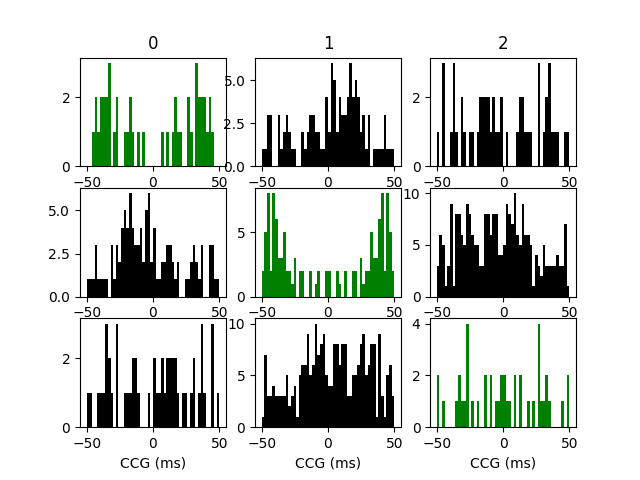

In [186]:
si.plot_crosscorrelograms(we, unit_ids=[0,1,2])

# 7. Viewers <a class="anchor" id="viewers"></a>

The `spikeinterface-gui` allows you to interactively explore a spike sorting output once waveforms are extracted.


### Exercise 7a) Use the `spikeinterface-gui` to epxlore the sorting output

Launch the `sigui` on the waveforms folder and explore all different views.

- Can you find some bad units?
- Are there missed spikes or spike sorting errors?

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

In [ ]:
!sigui waveforms_si

# 8.Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymertics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [188]:
print(si.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [192]:
qc = si.compute_quality_metrics(we)

/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/qualitymetrics/misc_metrics.py:404: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn("Amplitude PDF does not have a unique minimum! More spikes might be required for a correct "


In [193]:
display(qc)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff,isolation_distance,l_ratio,d_prime
0,200,0.666667,0.46,33.192932,0.000000,0.000000,0,0.004064,191.292839,0.011059,8.805304
1,1565,5.216667,0.95,20.553419,0.081658,0.006667,2,0.000518,221.483966,0.000835,10.160661
2,444,1.480000,0.85,16.730797,0.507264,0.003333,1,0.033018,105.112232,0.087036,5.107828
3,2775,9.250000,1.00,32.735031,0.000000,0.000000,0,0.000518,473.054277,0.027085,11.055240
4,147,0.490000,0.49,13.731914,0.000000,0.000000,0,0.001760,78.747641,0.058923,3.781103
5,5076,16.920000,1.00,16.441628,0.228986,0.196667,59,0.000518,102.787904,0.079952,5.755089
6,176,0.586667,0.59,13.962802,0.000000,0.000000,0,0.245189,62.477094,0.318613,4.110322
7,1134,3.780000,0.98,5.916869,2.021842,0.086667,26,0.000518,33.184760,3.939651,1.543783
8,2279,7.596667,0.99,15.164406,0.173282,0.030000,9,0.006518,74.920717,0.089894,5.827863
9,453,1.510000,0.92,9.711898,0.974616,0.006667,2,0.091606,47.528500,1.220595,3.528490


For more information about these waveform features, we refer to this 2 doc

  * [Allen documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from Josh Siegle.

  * [spikeinterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) from SI team

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

In [194]:
snr_thresh = 5
isi_viol_thresh = 0.2

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [195]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

snr > 5 & isi_violations_rate < 0.2


and then we can use the query to select units:

In [196]:
keep_units = qc.query(our_query)
keep_unit_ids = keep_units.index.values

In [197]:
sorting_auto = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 21
Number of units after curation: 18


### 8a) Extract waveforms on the curated sorting and explore the output in the spikeinterface-gui

Re-extract waveforms using the curated output and explore the results.

Is the spike sorting quality improved?

### 8a) SOLUTION



In [198]:
# choose a different folder!
we_curated = si.extract_waveforms(recording_saved, sorting_auto, folder=base_folder/"waveforms_si_curated",
                                  progress_bar=True, n_jobs=1, total_memory="500M", overwrite=True)
print(we_curated)

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

WaveformExtractor: 16 channels - 18 units - 1 segments
  before:60 after:80 n_per_units:500


In [169]:
!sigui waveforms_si_curated

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/core/baserecording.py:330: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn('There is no Probe attached to this recording. Creating a dummy one with contact positions')


# 9. Exporters <a class="anchor" id="exporters"></a>

The `exporters` module provides functions to export the spike sorting results to different frameworks.

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [200]:
from spikeinterface.exporters import export_to_phy

In [201]:
export_to_phy(we_curated, output_folder=base_folder/'phy',
              n_jobs=4, progress_bar=True, chunk_duration='1s')

write_binary_recording with n_jobs = 4 and chunk_size = 20000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/300 [00:00<?, ?it/s]

Run:
phy template-gui  /data_local/DataSpikeSorting/data_tutorial/practice_pipeline/phy/params.py


In [177]:
%%capture --no-display
!phy template-gui phy/params.py

<img src="phy.png" />

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [179]:
sorting_phy_curated = se.PhySortingExtractor('phy/', exclude_cluster_groups=['noise'])

In [182]:
print(f"Number of units before curation: {len(sorting_auto.get_unit_ids())}")

# Manually labeled 3 units as noise
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

Number of units before curation: 13
Number of units after curation: 10


## Export spike sorting report

The SpikeInterface report automatically saves summary and unit-specific views to save and inspect your spike sorting output.

In [203]:
from spikeinterface.exporters import export_report

In [204]:
%%capture --no-display
export_report(waveform_extractor=we_curated, output_folder=base_folder/"SI_report", format="pdf", 
              metrics=qc)